# Untitled Notebook

What's this notebook about?

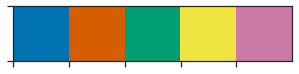

In [1]:
import sys
import os
from glob import glob
import random
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import upsetplot
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'gene_id', 'score', 'strand',
    'wass_dist', 'wass_dir', 'wass_pval', 'wass_fdr',
    'ks_stat',  'ks_pval', 'ks_fdr',
    'hm_pval', 'hm_fdr',
    'nreads_cntrl', 'nreads_treat'
]

fpa_vs_col0 = pd.read_csv(
    '../pipeline/fpa8_vs_col0/apa_results/fpa_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)

FPAox_vs_col0 = pd.read_csv(
    '../pipeline/35SFPA_vs_col0/apa_results/35SFPA_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)

FPAox_vs_col0.head()

,chrom,start,end,gene_id,score,strand,wass_dist,wass_dir,wass_pval,wass_fdr,ks_stat,ks_pval,ks_fdr,hm_pval,hm_fdr,nreads_cntrl,nreads_treat
0,1,6787,8666,AT1G01020,28,-,27.7,-22.1,1.0000,1.000,172,258,NaN,NaN,NaN,NaN,NaN
1,1,23518,31227,AT1G01040,26,+,26.1,7.3,0.9640,1.000,212,306,NaN,NaN,NaN,NaN,NaN
2,1,31169,32670,AT1G01050,6,-,5.7,3.5,1.0000,1.000,506,786,NaN,NaN,NaN,NaN,NaN
3,1,33364,37061,AT1G01060,60,-,60.5,60.4,0.2510,0.764,114,150,NaN,NaN,NaN,NaN,NaN
4,1,44969,46789,AT1G01080,26,-,26.5,-24.4,0.0109,0.179,390,637,NaN,NaN,NaN,NaN,NaN


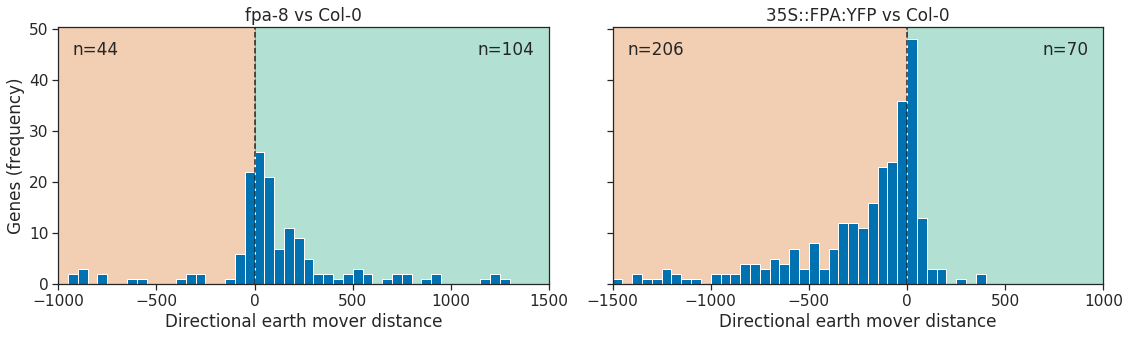

In [3]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2, sharey=True)

ax_it = zip(
    axes,
    [fpa_vs_col0, FPAox_vs_col0],
    [-1000, -1500],
    [1500, 1000],
    ['fpa-8 vs Col-0', '35S::FPA:YFP vs Col-0'],
)

for ax, df, lower_bound, upper_bound, title in ax_it:
    sig = df.query('wass_fdr < 0.05 & wass_dist > 25')
    ax.hist(sig.wass_dir, bins=50, range=(lower_bound, upper_bound))
    ax.axvline(0, ls='--', color='#252525')
    ax.axvspan(lower_bound, 0, color=pal[1], zorder=0, alpha=0.3)
    ax.axvspan(0, upper_bound, color=pal[2], zorder=0, alpha=0.3)
    ax.set_xlim(lower_bound, upper_bound)

    n_prox = len(sig.query('wass_dir < 0'))
    n_dist = len(sig.query('wass_dir > 0'))

    ax.annotate(
        xy=(0.03, 0.89),
        s=f'n={n_prox}',
        xycoords='axes fraction'
    )
    ax.annotate(
        xy=(0.97, 0.89),
        s=f'n={n_dist}',
        ha='right',
        xycoords='axes fraction',
    )
    ax.set_xlabel('Directional earth mover distance')
    ax.set_ylabel('')
    ax.set_title(title)
axes[0].set_ylabel('Genes (frequency)')
plt.tight_layout()
#plt.savefig('figures/nanopore_fpa_35FPA_APA.svg')
plt.show()

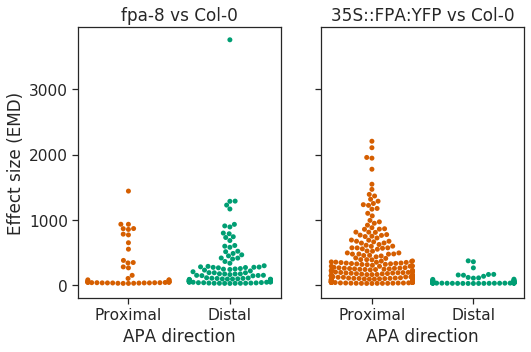

In [4]:
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

sns.swarmplot(
    x=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[0],
    palette=pal[1:3]
)

sns.swarmplot(
    x=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[1],
    palette=pal[1:3]
)
axes[0].set_title('fpa-8 vs Col-0')
axes[1].set_title('35S::FPA:YFP vs Col-0')
#axes[0].set_ylim(-50, 1100)
axes[0].set_ylabel('Effect size (EMD)')
axes[1].set_ylabel('')
axes[0].set_xticklabels(['Proximal', 'Distal'])
axes[1].set_xticklabels(['Proximal', 'Distal'])
axes[0].set_xlabel('APA direction')
axes[1].set_xlabel('APA direction')
plt.show()

In [5]:
genes_tested_in_both = set(fpa_vs_col0.gene_id).intersection(FPAox_vs_col0.gene_id)
fpa_distal = set(fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').gene_id)
FPAox_proximal = set(FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').gene_id)

print(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

stats.hypergeom.sf(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

30 12024 104 206


1.6886723193075758e-30

In [12]:
with pd.ExcelWriter('./helicos_fpa8_35SFPA_alternative_polya.xlsx') as xl:
    fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').to_excel(xl, sheet_name='fpa8_distal')
    fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').to_excel(xl, sheet_name='fpa8_proximal')
    FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').to_excel(xl, sheet_name='35SFPA_distal')
    FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').to_excel(xl, sheet_name='35SFPA_proximal')

In [14]:
!grep AT3G15270 /cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/vir_fpa_35SFPA_rnaseq/differential_expression/edgeR/35SFPA_vs_col0.tsv

AT3G15270	-0.32751141590461536	1.4871520584145859	1.7705738568904756	0.18331107567525878	0.30684256697238943	1.391547899686776	1.615369931917572	2.015227452102765	1.5836062767295247	1.702507398511807	1.5374660544710064	2.0628567567106577	1.1411684706407232	1.5354554465439418	0.4914014809873303	1.4882591966408443	0.6219603242387707
